# Chapter 6: Bio-inspired optimization

*Selected Topics in Mathematical Optimization*

*2016-2017*

**Bernard De Baets**

**Michiel Stock**

**Raúl Pérez-Fernández**

![Yes, this is how it works...](Figures/evolve_alg.gif)

In [1]:
from random import random, choice
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
%matplotlib inline

## Introduction and general idea

The open (or obsessive) mind can find optimization everywhere in the world around him. Ants find the optimal paths from food to their nest, rivers stream to maximize their water flow, plants maximize the amount of sunlight captured with their leafs and many of the laws of physics can be formulated as a minimization of energy. Bio-inspired optimization, or bio-inspired computing in general, borrows ideas from nature to solve complex problems. A central theme among these paradigms is that they use simple, local manipulations from which the general computation is an emergent property. Many also make use of a **population** of candidate solutions which is improved iteratively.

Bio-inspired optimization algorithms (BIOAs) are often applied for more complex problems discussed so far. Many real-word problems are often over-or underconstrained, lack detailed information about the target function (e.g. no gradient can be computed) or deal with complex 'structured data'. Examples of such problems which (bio)engineers routinely deal with include designing an antenna, callibrating a forest fire model or create a new functional peptide (topic of this project).

Contrary to most of the algorithms discussed so far, BIOAs often lack theoretical guarantees, both on their running time and on the quality of the solution. It is not uncommon to let such algorithms run for days or weeks. Since these algorithms do not exploit the structure or the gradient of the target function, only function evalutions are used. This is especially costly when evaluating the target function is expensive, for example when determining the parameters of a large set of ordinary differential equations. Furthermore, most bio-inspired optimization algorithms have some hyperparameters which must be tuned to the problem, otherwise the optimization might run badly.

Despite these drawbacks, BIOAs also have many merits. Because they are very flexible, they can be applied to almost any optimization problem. For some problem classes (such as NP-hard problems), there are no efficient exact solvers, making for example the traveling salesman problem unsolvable for moderately large instances using standard techniques. BIOAs on the other hand can often generate reasonable solutions quite quickly. Furthermore, BIOAs work **progressive**, meaning that intermediate solutions can be obtained at any time. Hence, even if the optimization process is prematurely aborted, we still have some result to show for our effort.

BIOA come in [many flavors](https://arxiv.org/pdf/1307.4186.pdf), which is one of the reasons why some of researchers dislike them. An important class of algorithms try to mimic swarm intelligence, for example how ants find their way in their surroundings is implemented in ant colony optimization. In this project we will work with genetic algorithms (GAs), which are based on the most succesful optimization algorithm in nature: evolution. GAs use *in silico* evolution to obtain iteratively better solutions for a problem. Most GAs are based on the following four concepts:
- **maintenance of a population**
- **creation of diversity**
- **a natural selection**
- **genetic enheritance**

![](Figures/GAconcept.png)

## Genetic representation

![Genotype, phenotype and fitness.](Figures/encoding.png)

**genotype**: reprentation of a candidate solution on which the genetic algorithm will operate

- often discrete representation (e.g. binary encoding of numbers)
- ideally covers the space of optimal solutions (prior knowledge)
- recombination should have high probability of generating increasingly better individuals

**phenotype**: the candidate solution in a representation of the problem

- **decoding**: translating genotype into phenotype
- **encoding**: translating the phenotype in genotype

Since the genetic operators of the GA only work on the genotype, only decoding has to be defined.

**fitness**: the quality of the solution, will be used to select individuals for the next generation

## Selection and reproduction

**Selection** is the procedure such that individuals with a higher fitness are more likelily to go to the next generation.

Usually the population size is fixed. individuals with high fitness are likely to be selected multiple times, those with low fitness might not be selected.

**Roulette wheel selection**

![Roulette wheel selection chooses individuals proportional to their fitness.](Figures/roulettewheel.png)

A new population of $n$ individuals is chosen by chosing individuals proportional to their fitness:

$$
p(i) = \frac{f(i)}{\sum_{j=1}^nf(j)}\,,
$$
with $p(i)$ the probability of choosing individual $i$ and $f(i)$ the fitness of individual $i$.

Drawbacks:
- only when fitness is positive
- selection process dependent on (nonlinear) scaling of fitness

**Tournament selection**

Randomly choose two individuals, retain the individual with the highest fitness for the population of the next generation (pick one at random if fitness is equal). Repeat as many times as there are individuals in the population.

Below is an illustration of the two types of selection.

In [2]:
# generate random initial population
population_fitness = [np.random.randn()**2 for _ in range(1000)]

In [3]:
# roulette wheel selection
population_fitness_roulette = []
finess_sum = np.sum(population_fitness)
while len(population_fitness_roulette) < len(population_fitness):
    fitness = choice(population_fitness)
    if fitness / finess_sum > random():
        population_fitness_roulette.append(fitness)

In [4]:
# tournament selection
population_fitness_tournament = []
while len(population_fitness_tournament) < len(population_fitness):
    selected_fitness = max(choice(population_fitness), choice(population_fitness))
    population_fitness_tournament.append(selected_fitness)

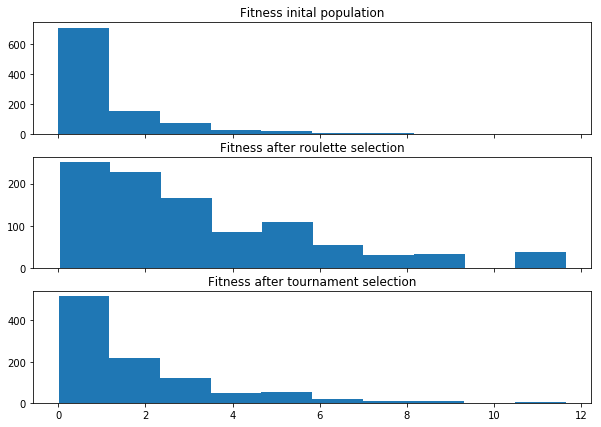

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10, 7))

ax0.hist(population_fitness)
ax1.hist(population_fitness_roulette)
ax2.hist(population_fitness_tournament)

ax0.set_title('Fitness inital population')
ax1.set_title('Fitness after roulette selection')
ax2.set_title('Fitness after tournament selection')

**Elitism**: after selection and recombination, the individual with the highest fitness is often retained in the population. This way the best fitness of the population will never decrease.

## Genetic operators

Selection increases the average quality of the candidate solutions, at the cost of decreasing the diversity

**Recombination** is the process of bringing back diversity into the population *without any regards for fitness*.

### Mutations

- small change to the genotype
- mutations operate at the level of the individual
- example: flipping a bit in a binary representation
- example: adding a normally distributed number to a real value

### Crossover

**Crossover** recombined two individuals (parents) into two children by randomly switching parts of the genotype

Types of crossover:
- **one-point**: select randomly a crossover point on each of the two strings and swapping around this point
- **multipoint**: the same, but with $n$ crossover points
- **uniform**: each element is switched between the parents with a certain probability (usually 50%)
- specialised crossovers for graphs, cycles or trees

![Examples of simples crossover.](Figures/crossover.png)

## Algorithms

### Hill climbing

- iterative improvement of starting point
- converges to local optimum (dependent on starting position)
- usually executed multiple times with different initial conditions

```
Hill climbing algorithm
    choose a random current_solution
    local := FALSE  // assume solution is not in local optimum
    
    while local is FALSE:
        set local to TRUE
        for all neighbors of current_solution:
            if neighbor improves current_solution:
                set local to FALSE
                current_solution := neighbor
                
    return current_solution
```

**Advantages**:
- easy to implement
- only needs the scoring function and a definition of neighborhood to search

**Disadvantages**:
- converges to a local optimum that is dependent of the starting position
- no guarantees on the quality of the solution
- no guarantees on the running time

### Simulated Annealing

- instead of scanning the whole neighborhood, one candidate solution is randomly chosen
    - if the new solution has a higher fitness: accept it
    - if it has a lower fitness, accept with probability $e^{\Delta f / T}$
- the temperature $T$ controls the **exploration** vs **exploitation** trade-off
- the temperature is gradually decreased when running the algorithm

```
Simulated annealing algorithm(Tmax, Tmin, r, kT)
    choose random initial point x
    T := Tmax
    while T > Tmin
        repeat kT times
            randomly choose xn from neigborhood of x
            if f(xn) > f(x)
                x := xn
            else with probability exp( (f(xn) - f(x))/T )
                x := xn
         T := T * r
    return x  
```

**Example of simulated annealing**

$$
\min_x\ f(x) = |x\cos(x)| + \frac{|x|}{2}\,.
$$

During each step, a new candidate solution is selected randomly according to

$$
x_n = x + \Delta x\,,
$$
with
$$
\Delta x \sim N(0, \sigma)\,.
$$

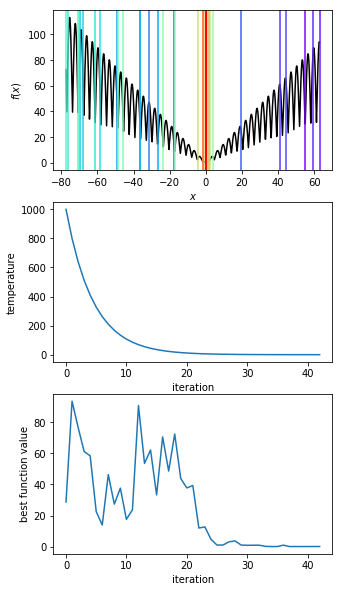

In [6]:
from simulated_annealing_demo import plot_SA_example

f_toy_example = lambda x : np.abs(x * np.cos(x)) + 0.5 * np.abs(x)
x0 = 55
hyperparameters = {'Tmax' : 1000, 'Tmin' : 0.1,
                    'r' : 0.8, 'kT' : 10, 'sigma' : 5}

plot_SA_example(f_toy_example, x0, hyperparameters)

### Genetic algorithm

```
Genetic algorithm(population size, number of generations, pmut, pcross)
    initialize a random population
    repeat for a number of generations
        use tournament selection to generate a new population
        recombinate the new population using mutations and crossover
        apply elitism
    return best individual of final population
```

## Project: Designing bio-active peptides

Some peptides have an anti-microbial function. These peptides originate from the innate immuum system and are found in nearly all classes of life. These peptides often have a general mode of action and are thus effective against a broad range of microorganisms and it is quite difficult to acquire resistence for these organisms. As such they are an attractive alternative to conventional antibiotics.

![Two possible mechanisms how a peptide can target a bacterial cell.](Figures/Modes_of_action.png)

In this project we will use genetic algorithms (in the very broad sense) to design and optimize a novel anti-microbial peptide. For this, we have downloaded a fasta file containing the amino acid sequence of over two thousand anti-microbial peptides as a reference set from the [Collection of Anti-Microbial Peptides](http://www.camp.bicnirrh.res.in/) database. Using a machine learning technique called kernel embedding, we have modelled the distribution of these peptides. This model can be used to generate a score between 0 and 1 for a given peptide, representing our belief that the peptide has an anti-microbial function (higher is better). The model is externally developed and is to us a black box.

For example:

In [7]:
from anti_microbial_peptide_model import score_peptide

Loading the sequences...
Loading the features...
Finished!


In [8]:
print(score_peptide('ASRTYUIPUYGRVHHGY'))  # a random peptide

6.35396112848e-05


In [9]:
print(score_peptide('SKITDILAKLGKVLAHV'))  # a peptide from the database

0.00770537270675


In [10]:
%timeit score_peptide('ASRTYUIPUYGRVHHGY')  # time to score a peptide

1000 loops, best of 3: 317 µs per loop


We will try to find a new peptide with a length of twenty amino acids with the highest possible score according to the given model. To this end, hill climbing, simulated annealing and genetic algorithms will be used.

For the problem setting at hand, we clarify the following terminology:
- The **neigborhood** of a peptide: the set of all peptides which differ with exactly one amino acid compared to the given peptide
- When a **mutation** occurs, a residue of a peptide is replaced by a randomly chosen amino acid. In our implementation of simulated annealing and the genetic algorithm, each amino acid in a peptide has a small fixed probability `pmut` to be mutated.
- During a **crossover** event between two peptides, at each position the corresponding residues of the peptides are either switched or remain unchanged with equal probability. Crossovers occur between two randomly selected individuals with a probability `pcross`.

**Assignment 1**

Complete the implementation of the function `hill_climbing` to bring either a given peptide or a randomly generated peptide of a given length to a local optimum. Run the algorithms ten times to generate optimized peptides of length twenty. What scores do you get? Describe these plots.

In [11]:
from protein_sequence_features import amino_acids

print(amino_acids)
print(len(amino_acids))

['F', 'M', 'D', 'I', 'T', 'P', 'A', 'E', 'W', 'R', 'G', 'N', 'V', 'Q', 'S', 'C', 'H', 'K', 'Y', 'L']
20


In [12]:
def explore_peptide_region(peptide, scoring):
    """
    Searches all neighboring peptides of a given peptide that differ exactly one
    amino acid
    """
    best_score= 0
    best_peptide= ''
    for i in range(0,len(peptide)):
        for AA in amino_acids:
            neighbour= peptide[:i]+AA+peptide[i+1:]
            score= scoring(neighbour)
            if score > best_score:
                best_score= score
                best_peptide= neighbour
    return best_score, best_peptide

def hill_climbing(peptidesize=None, peptide=None, scoring=score_peptide):
    """
    Uses hill climbing to find a peptide with a high score for
    antimicrobial activity.

    Inputs:
        - peptidesize : give size if stated from a randon peptide
        - peptide : optionally give an intial peptide to improve
        - scoring : the scoring function used for the peptides

    Outputs:
        - peptide : best found peptide
        - best_scores : best scores obtained through the iterations
    """
    assert peptidesize is not None or peptide is not None
    # if no peptide is made, give a random one
    if peptide is None:
        peptide = ''
        for res in range(peptidesize):
            peptide += choice(amino_acids)
    else:
        peptidesize = len(peptide)
    best_scores = [scoring(peptide)]
    peptides = [peptide]
    while True:
        new_score, new_peptide = explore_peptide_region(peptides[-1],scoring) 
        if new_score > best_scores[-1]:
            peptides.append(new_peptide)
            peptide= new_peptide
            best_scores.append(new_score)
        else:
            break
    return peptide, best_scores

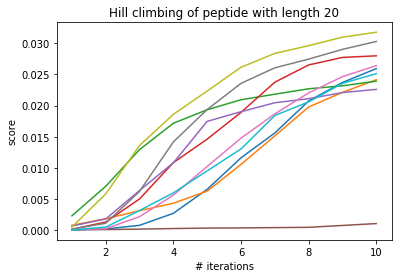

CPU times: user 24.4 s, sys: 300 ms, total: 24.7 s
Wall time: 24.4 s


In [13]:
%%time 
for i in range(0,10):
    best_peptide, scores= hill_climbing(peptidesize=20)
    plt.plot(range(1,11),scores[0:10])
plt.xlabel("# iterations")
plt.ylabel("score")
plt.title("Hill climbing of peptide with length 20")
plt.show()
# for ten runs

COMMENT ON THIS PLOT? HOW ARE THE DIFFERENT RUNS THE SAME AND WHAT DO THEY HAVE IN COMMON?

All scores improve during the following iterations, only the rate of improvement differs (sometimes markedly). Most peptide scores end around the same score, indicating that either the scores are nearing a local/global maximum or that the amount of improvement that can be obtained with adjustment of one peptide is rather limited. 

**Assignment 2**

Hill climbing greedily improves the given peptide until no single change of in amino acid residus increases the score. The solution of hill climbing is likely to be a local optimum (and not necessarily a good one!).

We will try to generate better peptides using simulated annealing (which only uses mutations to generate diversity in the candidate solutions) and a genetic algorithm (which uses both mutations as well as crossover to generate novel peptides). 

1. Complete the functions to generate diversity in the peptides. The function `mutate_peptide` takes a peptide as input and returns a new peptide where each amino acid is changed by a randomly chosen other peptide with a probability `pmut`. The function `crossover_peptides` requires two peptides of equal length as input and outputs the corresponding random crossover peptides.
2. Complete the function `simulated_annealing` to optimize random peptide of fixed length. Try to find an optimal peptide of length twenty. Discuss how to choose good values for `Tmin`, `Tmax`, `r` and `kT`.
3. Finally, complete the function `genetic_algorithm`. You also have to complete the functions `tournament_selection` and `recombinate` which will be used in the main algorithm. Try to find the an optimal peptide of length twenty as well, using some trial and error to find the hyperparameters. 
4. Compare the quality of the solution using hill climbing, simulated annealing and the genetic algorithm. If you take code complexity and computation time into account, which would you try first for general problems?

In [26]:
def mutate_peptide(peptide, pmut=0.05):
    """
    Replaces each amino acid of the peptide with an arbitrary chosen
    amino acid with a probability pmut
    """
    mutated_peptide= ""
    mutated= np.random.choice([0, 1], size=(len(peptide,)), p=[1-pmut, pmut])
    for i in range(0,len(peptide)):
        if mutated[i] == 0:
            mutated_peptide+= peptide[i]
        else:
            AA_group= [AA for AA in amino_acids if AA != peptide[i]]
            mutated_peptide += np.random.choice(AA_group)
    return mutated_peptide

def crossover_peptides(peptide1, peptide2,pcross):
    """
    Performs crossover for two peptides, each position is switched with equal
    probability.

    Inputs:
        - peptide1, peptide2

    Outputs:
        - crossed_peptide1, crossed_peptide2
    """
    crossed_peptide1= ""
    crossed_peptide2= ""
    crossed= np.random.choice([0, 1], size=(len(peptide1,)),p= [1-pcross,pcross])
    for i in range(0,len(peptide1)):
        if crossed[i] == 0:
            crossed_peptide1 += peptide1[i]
            crossed_peptide2 += peptide2[i]
        else:
            crossed_peptide1 += peptide2[i]
            crossed_peptide2 += peptide1[i]
    return crossed_peptide1, crossed_peptide2

In [27]:
peptide1 = 'AAAAAAAAAAAA'
peptide2 = 'CCCCCCCCCCCC'

In [28]:
print(mutate_peptide(peptide1, pmut=0.1))

AAEAAAAAAAAA


In [29]:
print(*crossover_peptides(peptide1, peptide2,pcross= 0.5))

CAACCCCCCCAA ACCAAAAAAACC


In [30]:
def simulated_annealing(peptidesize, Tmax, Tmin, pmut, r, kT,
                                                scoring=score_peptide):
    """
    Uses simulated annealing to find a peptide with a high score for
    antimicrobial activity.

    Inputs:
        - peptidesize : length of the peptide
        - Tmax : maximum (starting) temperature
        - Tmin : minimum (stopping) temperature
        - pmut : probability of mutating an amino acid in the peptide
        - r : rate of cooling
        - kT : number of iteration with fixed temperature
        - scoring : the scoring function used for the peptides

    Outputs:
        - peptide : best found peptide
        - fbest : best scores obtained through the iterations
        - temperatures : temperature during the iterations
    """
    # create intial peptide
    peptide = ''
    for _ in range(peptidesize):
        peptide += choice(amino_acids)

    temp = Tmax
    fstar = scoring(peptide)
    fbest = [fstar]
    temperatures = [temp]

    while temp > Tmin:
        for _ in range(kT):
            new_peptide= mutate_peptide(peptide,pmut) 
            new_score= scoring(new_peptide)
            if new_score > fstar:
                peptide= new_peptide
                fstar= new_score
            else:
                if np.random.choice([0,1], p= [(1-np.exp((new_score - fstar)/temp)),np.exp((new_score - fstar)/temp)])==1:
                    peptide= new_peptide
                    fstar= new_score
        fbest.append(fstar)  # save best value
        temperatures.append(temp)  # save best temperature
        temp *= r
    return peptide, fbest, temperatures

In [49]:
%%time
peptide_SA, fitness, temperature = simulated_annealing(peptidesize=20, Tmax= 200, Tmin= 0.001, r= 0.95, kT=10, pmut=0.05)

CPU times: user 940 ms, sys: 8 ms, total: 948 ms
Wall time: 944 ms


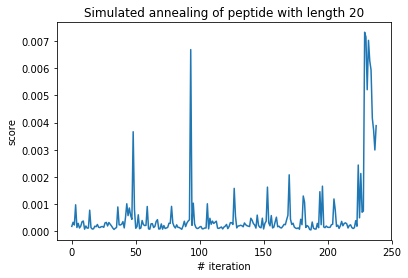

In [34]:
# make a plot for simulated annealing
plt.plot(range(0,len(fitness)),fitness)
plt.xlabel("# iteration")
plt.ylabel("score")
plt.title("Simulated annealing of peptide with length 20")
plt.show()

DESCRIBE THE EFFECT OF THE HYPERPARAMETERS. MAKE A PLOT TO ILLUSTRATE THE BEHAVIOUR BELOW.

Tmax is the parameter that affects the number of the iterations and the chances that a less approriate solution is accepted at the beginning stages. As high values of this paramter cause random acceptance of all neighbours (p-values are high) and bring about a long range of randomization, it is not very effective to use too high values. As can be seen in the picture below, Tmin in the most important parameter to obtain good results. The lower Tmin, the better the approximation to the optimal solution, but the longer the algorithm takes to complete. R has a similar effect as Tmin, a better r-value (here higher r-value) will give better results, but it increases the computing time. KT determines the amount of neighbours that are evaluated before the temperature decreases. A low kT value will not explore a lot of neighbours, giving the algorithm little opportunity to find a better neighbour before continuing. Too high kT values will give long computing times and does not increase the efficiency of the algorithm. The pmut determines the range of the peptide neighbourhood. Small pmut-values will result in little changes in the peptide, causing the result to become more stagnant. Too high pmut values will result in a randomization in which new peptides are barely related to the previous one, causing the algorithm to pick the best peptide out of a random peptide collection, without optimization of a peptide that was already proven to be better than the previous one. 

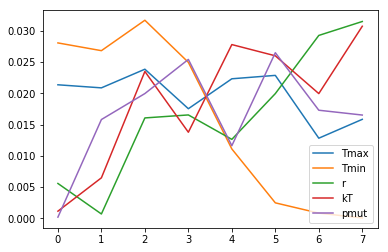

In [59]:
Tmin= 0.0001
Tmin_range= [0.0000001,0.000001,0.00001,0.0001,0.0005,0.001,0.005, 0.01]
Tmax= 100
Tmax_range= [1,2,5,10,20,50,100,200]
r= 0.9
r_range= [0.5,0.6,0.7,0.8,0.85,0.9,0.95, 0.99]
kT= 10
kT_range= [1,5,10,15,20,25,30,40]
pmut= 0.1
pmut_range= [0.001,0.01,0.05,0.1,0.15,0.2,0.25,0.3]

result_fitness= np.zeros([5,8])
for i in range(0,8):
    _, fitness, _ = simulated_annealing(peptidesize=20, Tmax= Tmax_range[i], Tmin= Tmin, r= r, kT=kT, pmut=pmut)
    result_fitness[0,i]= fitness[-1]
    _, fitness, _ = simulated_annealing(peptidesize=20, Tmax= Tmax, Tmin= Tmin_range[i], r= r, kT=kT, pmut=pmut)
    result_fitness[1,i]= fitness[-1]
    _, fitness, _ = simulated_annealing(peptidesize=20, Tmax= Tmax, Tmin= Tmin, r= r_range[i], kT=kT, pmut=pmut)
    result_fitness[2,i]= fitness[-1]
    _, fitness, _ = simulated_annealing(peptidesize=20, Tmax= Tmax, Tmin= Tmin, r= r, kT=kT_range[i], pmut=pmut)
    result_fitness[3,i]= fitness[-1]
    _, fitness, _ = simulated_annealing(peptidesize=20, Tmax= Tmax, Tmin= Tmin, r= r, kT=kT, pmut=pmut_range[i])
    result_fitness[4,i]= fitness[-1]

labels= ["Tmax","Tmin","r","kT","pmut"]
for i in range(0,5):
    plt.plot(range(0,8), result_fitness[i,:], label= labels[i])

plt.legend()
plt.show()

In [69]:
# EXPERIMENT WITH THE HYPERPARAMETERS OF SA HERE
number= 50
Tmin= np.zeros(number)
Tmax= np.zeros(number)
r= np.zeros(number)
kT= np.zeros(number)
pmut= np.zeros(number)
result_fitness= np.zeros(number)
for i in range(0,number):
    Tmin[i]= choice([0.0000001,0.000001,0.00001,0.0001])
    Tmax[i]= choice([1,2,5,10])
    r[i]= choice([0.85,0.9,0.95, 0.99])
    kT[i]= choice([10,15,20,25,30])
    pmut[i]= choice([0.05,0.1,0.15,0.2])
    peptide_SA, fitness, temperature = simulated_annealing(peptidesize=20, Tmax= Tmax[i], Tmin= Tmin[i], r= r[i], 
                                                           kT=int(kT[i]), pmut=pmut[i])
    result_fitness[i]= fitness[-1]

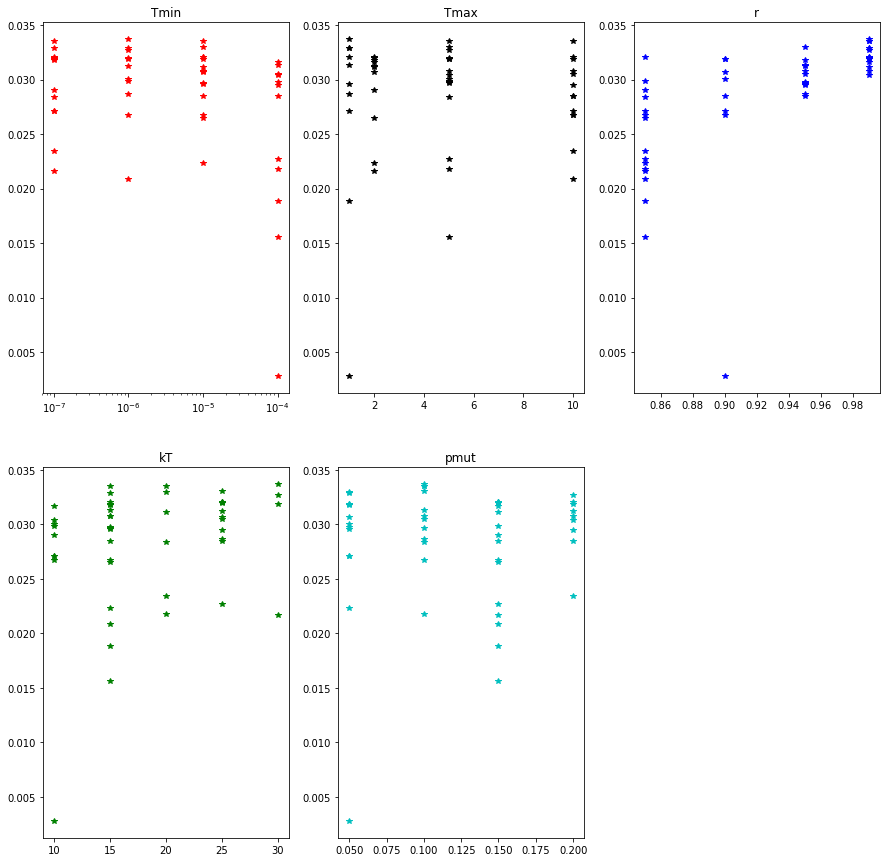

In [70]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(231)
ax1.semilogx(Tmin, result_fitness, 'r*')
ax1.set_title("Tmin")

ax2 = fig.add_subplot(232)
ax2.plot(Tmax, result_fitness, 'k*')
ax2.set_title("Tmax")

ax3 = fig.add_subplot(233)
ax3.plot(r, result_fitness, 'b*')
ax3.set_title("r")

ax4 = fig.add_subplot(234)
ax4.plot(kT, result_fitness, 'g*')
ax4.set_title("kT")

ax5 = fig.add_subplot(235)
ax5.plot(pmut, result_fitness, 'c*')
ax5.set_title("pmut")

plt.show()

In [94]:
%%time
peptide_SA, fitness, temperature = simulated_annealing(peptidesize=20, Tmax= 2, Tmin= 0.0001, r= 0.99, kT=15, pmut=0.1)

CPU times: user 6.08 s, sys: 0 ns, total: 6.08 s
Wall time: 6.08 s


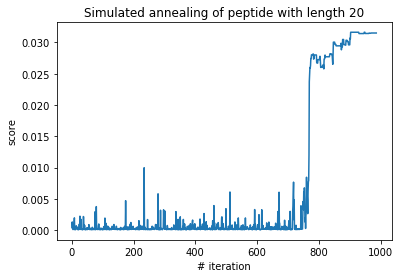

In [95]:
plt.plot(range(0,len(fitness)),fitness)
plt.xlabel("# iteration")
plt.ylabel("score")
plt.title("Simulated annealing of peptide with length 20")
plt.show()

In [72]:
def tournament_selection(scored_peptides):
    """
    Apply tournament selection on a list of scored peptides.

    Input:
        - scored_peptides : a list of scored peptides, each element is a tuple
                        of the form (score, peptide)
    Output:
        - selected_peptides : a list of peptides selected from scored_peptides
                        based on tournament selection (without the score)
    """
    selected_peptides= []
    for _ in range(0,len(scored_peptides)):
        first= choice(scored_peptides)
        second= choice(scored_peptides)
        if first[0] > second[0]:
            selected_peptides.append(first[1])
        else:
            selected_peptides.append(second[1])
    return selected_peptides


def recombinate(population, pmut, pcross):
    """
    Recombinates a population of peptides.

    Inputs:
        - population : a list of peptides
        - pmut : probability of mutating an amino acid
        - pcross : probability of two peptides crossing over

    Output:
        - recombinated_population
    """
    recombinated_population = []
    for _ in range(0,len(population)):
        first= choice(population)
        second= choice(population)
        first, second= crossover_peptides(first,second,pcross)
        peptide= choice([first,second])
        recombinated_population.append(mutate_peptide(peptide,pmut))
    # the population with mutation an cross over applied to
    return recombinated_population

In [73]:
def genetic_algorithm(peptidesize, n_iterations, popsize, pmut, pcross,
                                                    scoring=score_peptide):
    """
    Uses a genetic algorithm to find a peptide with a high score for
    antimicrobial activity.

    Inputs:
        - peptidesize : length of the peptide
        - n_iterations : number of iterations (generations)
        - popsize : size of the population
        - pmut : probability of mutating an amino acid in the peptide
        - pcross : probability of performing a crossover
        - scoring : the scoring function used for the peptides

    Outputs:
        - best_peptide : best found peptide
        - best_fitness_iteration : best scores obtained through the iterations
    """
    # initialize population
    population = []
    for _ in range(popsize):
        peptide = ''
        for _ in range(peptidesize):
            peptide += choice(amino_acids)
        population.append(peptide)

    # score peptides
    scored_peptides = [(scoring(peptide), peptide)
                        for peptide in population]
    best_fitness, best_peptide = max(scored_peptides)

    best_fitness_iteration = [best_fitness]

    for iter in range(n_iterations):
        population= tournament_selection(scored_peptides)
        population= recombinate(population,pmut,pcross)
        scored_peptides= [(scoring(peptide), peptide) for peptide in population]
        best_fitness, best_peptide = max(scored_peptides)
        best_fitness_iteration.append(best_fitness)

    return best_peptide, best_fitness_iteration

In [82]:
%%time
peptide_GA, best_fitness_iteration = genetic_algorithm(peptidesize=20, n_iterations=250,
                                        popsize=500, pmut=0.02, pcross=0.8, scoring=score_peptide)

CPU times: user 47.7 s, sys: 0 ns, total: 47.7 s
Wall time: 47.7 s


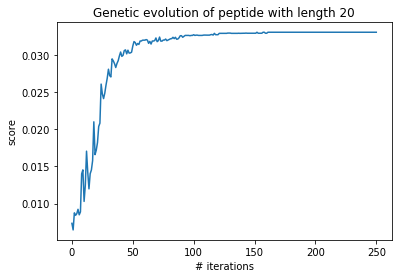

In [83]:
plt.plot(range(0,len(best_fitness_iteration)),best_fitness_iteration)
plt.xlabel("# iterations")
plt.ylabel("score")
plt.title("Genetic evolution of peptide with length 20")
plt.show()

DESCRIBE THE EFFECT OF THE HYPERPARAMETERS. MAKE A PLOT TO ILLUSTRATE THE BEHAVIOUR BELOW.
The number of iterations determines how long the population can develop and gain better characteristics. When the number of iterations is not high enough, the population will not reach its optimal score. Setting the number of iterations too high will increase the computation when the population has already stabilized around an optimal peptide score. The population size will give a variability to the set of peptides. Small populations will not contain a lot of different peptides and the number of combinations that can be made using this population is limited. Too big populations will increase the computing time and result in little improvement of the peptide. Pmut has already been explained for SA and has the same effect here. Pcross determines the recombination rate between "parent" peptides. Notice that pcross is a symmetric parameter around 0.5. A pcrosse value of 0.4 will have the same effect as one of 0.6. A pcross value of around 0 and 1 will result in little exchange between the individuals of the population, having the same effect as a small pmut variable. Values around 0.5 will cause major reorganization of the peptide and will slow down the formation of a stable the population (too much variablity). 

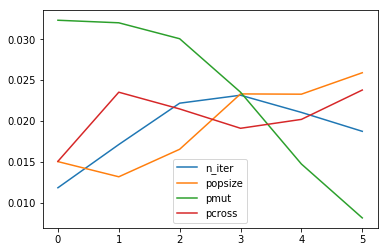

In [85]:
n= 150
n_range= [10,50,100,150,200,250]
popsize= 500
popsize_range= [50,100,200,500,750,1000]
pmut= 0.1
pmut_range= [0.001, 0.01,0.05,0.1,0.15,0.2]
pcross= 0.2
pcross_range= [0,0.1,0.2,0.3,0.4,0.5]

result_fitness= np.zeros([4,6])
for i in range(0,6):
    _, fitness = genetic_algorithm(peptidesize=20, n_iterations= n_range[i], popsize= popsize, pmut= pmut, pcross= pcross,
                                   scoring=score_peptide)
    result_fitness[0,i]= fitness[-1]
    _, fitness = genetic_algorithm(peptidesize=20, n_iterations= n, popsize= popsize_range[i], pmut= pmut, pcross= pcross,
                                   scoring=score_peptide)
    result_fitness[1,i]= fitness[-1]
    _, fitness = genetic_algorithm(peptidesize=20, n_iterations= n, popsize= popsize, pmut= pmut_range[i], pcross= pcross,
                                   scoring=score_peptide)
    result_fitness[2,i]= fitness[-1]
    _, fitness = genetic_algorithm(peptidesize=20, n_iterations= n, popsize= popsize, pmut= pmut, pcross= pcross_range[i],
                                   scoring=score_peptide)
    result_fitness[3,i]= fitness[-1]

labels= ["n_iter","popsize","pmut","pcross"]
for i in range(0,4):
    plt.plot(range(0,6), result_fitness[i,:], label= labels[i])

plt.legend()
plt.show()

In [86]:
%%time
peptide_GA, best_fitness_iteration = genetic_algorithm(peptidesize=20, n_iterations=150,
                                        popsize=500, pmut=0.01, pcross=0.1, scoring=score_peptide)

CPU times: user 29.4 s, sys: 0 ns, total: 29.4 s
Wall time: 29.4 s


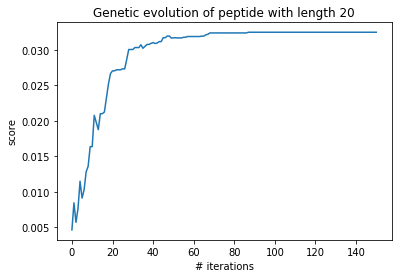

In [87]:
plt.plot(range(0,len(best_fitness_iteration)),best_fitness_iteration)
plt.xlabel("# iterations")
plt.ylabel("score")
plt.title("Genetic evolution of peptide with length 20")
plt.show()

In [96]:
print("Hill climbing")
%timeit best_peptide, scores= hill_climbing(peptidesize=20)
print(scores[-1])

print("Simulated annealing")
%timeit peptide_SA, fitness, temperature = simulated_annealing(peptidesize=20, Tmax= 2, Tmin= 0.0001, r= 0.99, kT=15, pmut=0.1)
print(fitness[-1])

print("Evolution")
%timeit peptide_GA, best_fitness_iteration = genetic_algorithm(peptidesize=20, n_iterations=150,popsize=500, pmut=0.01, pcross=0.1, scoring=score_peptide)
print(best_fitness_iteration[-1])

Hill climbing
1 loop, best of 3: 1.47 s per loop
0.0304560933775
Simulated annealing
1 loop, best of 3: 6.15 s per loop
0.0314901758368
Evolution
1 loop, best of 3: 29.3 s per loop
0.0325076800503


As Hill climbing performs only slightly less than the other methods and it has easier code and is faster, it is a good method to use when first exploring a general problem.

## References

Floreano, D. and Mattiussi, C., *'Bio-Inspired Artificial Intelligence'*. MIT Press (2008) [link](http://baibook.epfl.ch/)

Song, L.,Fukumizu, K. and Gretton, A. (2013), *'Kernel embeddings of conditional distributions'*. IEEE Signal Processing Magazine 30(4):98-111